#### 导入对应库

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm, trange
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

###### 确保设备（GPU或CPU）正确设置

In [4]:
# 确保设备（GPU或CPU）正确设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


#### 数据预处理和增强

In [5]:
# 数据预处理和增强
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG要求输入尺寸为224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 加载数据集并进行交叉验证拆分

In [6]:
dataset = torchvision.datasets.ImageFolder(root='melanoma_cancer_dataset/train', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)  # 适当减少批次大小以适应VGG
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

test_dataset = torchvision.datasets.ImageFolder(root='melanoma_cancer_dataset/test', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## 使用预训练的VGG16模型

In [8]:
model = torchvision.models.vgg16(pretrained=True)
# 修改最后的全连接层以适应我们的分类任务（2类）
model.classifier[6] = nn.Linear(4096, 2)

# 将模型移动到GPU
model = model.to(device)

### 定义损失函数和优化器

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)  # 调整学习率

### 训练和验证记录

In [10]:
num_epochs = 20
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.003, steps_per_epoch=len(train_loader), epochs=num_epochs)

### 定义早停机制

In [12]:
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []


### 使用一个循环进行多次训练（epoch），在每个epoch中对训练数据进行前向传播、损失计算、反向传播和参数更新

In [13]:
epoch_progress = trange(num_epochs, desc="Epochs", leave=True)

for epoch in epoch_progress:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(predicted.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    train_precision = precision_score(y_val_true, y_val_pred, average='macro')
    val_precision = precision_score(y_val_true, y_val_pred, average='macro')
    train_recall = recall_score(y_val_true, y_val_pred, average='macro')
    val_recall = recall_score(y_val_true, y_val_pred, average='macro')
    train_f1 = f1_score(y_val_true, y_val_pred, average='macro')
    val_f1 = f1_score(y_val_true, y_val_pred, average='macro')

    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    epoch_progress.set_postfix({
        "Train Acc": f"{train_accuracies[-1]:.4f}",
        "Val Acc": f"{val_accuracies[-1]:.4f}",
        "Train Loss": f"{train_losses[-1]:.4f}",
        "Val Loss": f"{val_losses[-1]:.4f}"
    })

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break



Epoch 1/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:19<00:00,  3.21it/s]

Epoch 2/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:19<00:00,  3.18it/s]

Epoch 3/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:18<00:00,  3.24it/s]

Epoch 4/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:19<00:00,  3.13it/s]

Epoch 5/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:19<00:00,  3.12it/s]

Epoch 6/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:19<00:00,  3.18it/s]

Epoch 7/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:18<00:00,  3.21it/s]

Epoch 8/20 - Validation: 100%|█████████████████████████████████████████████████████████| 61/61 [00:18<00:00,  3.24it/s]

Epoch 9/20 - Validation: 100%|█

### 绘图

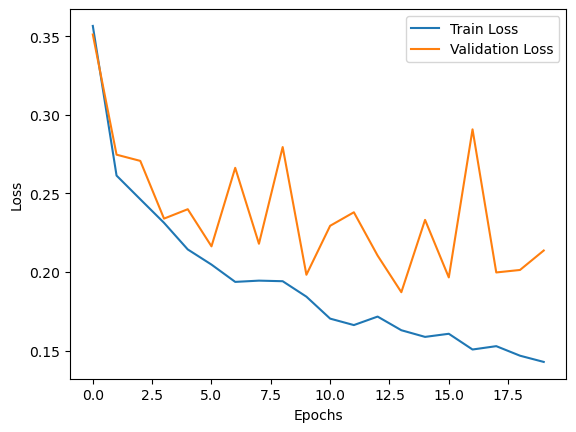

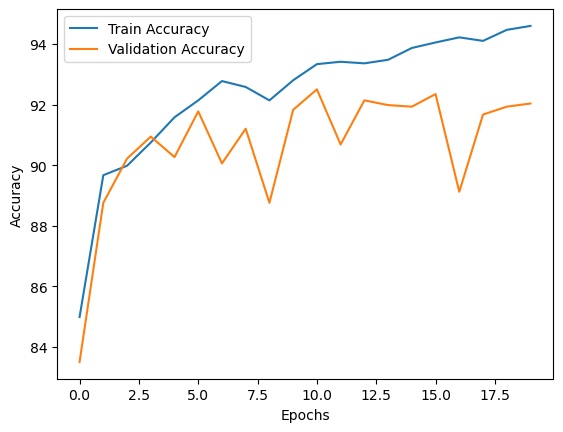

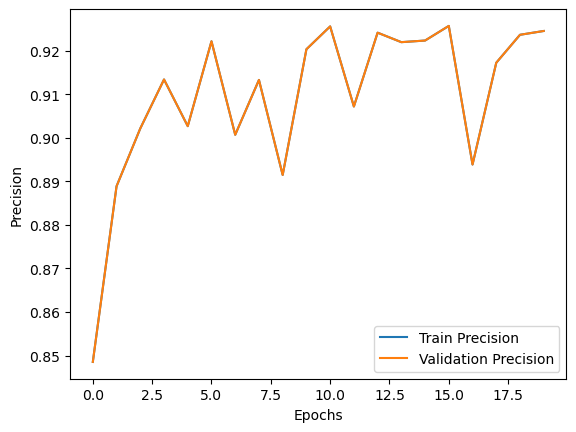

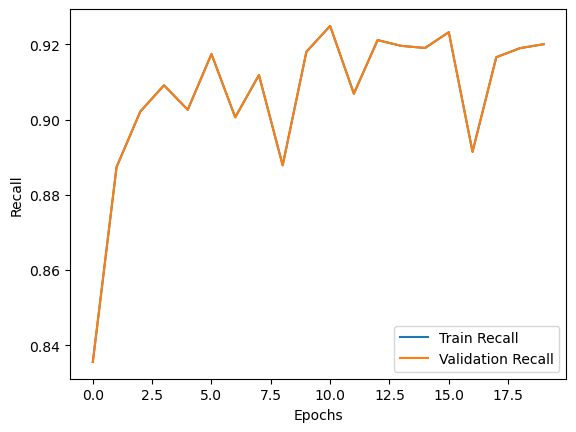

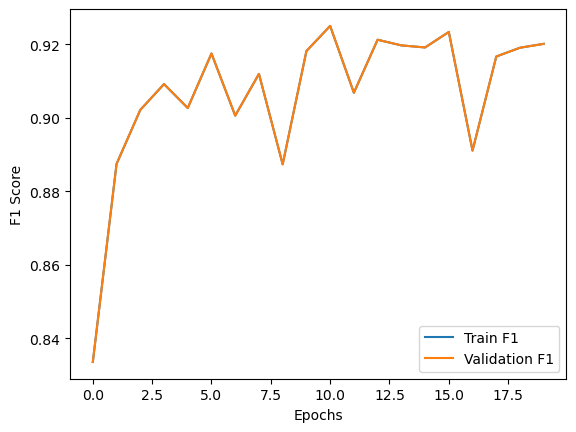

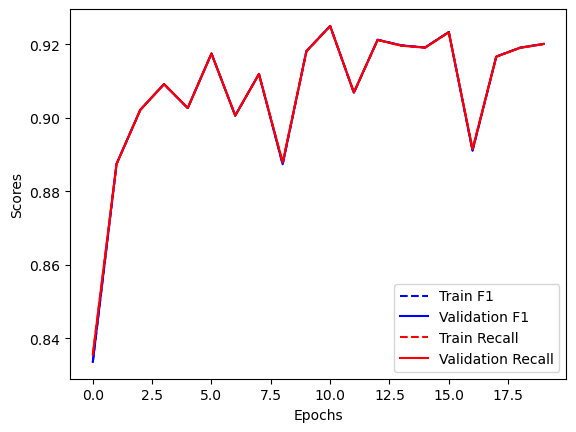

In [14]:
# 绘制训练和验证的损失曲线
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.figure()
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制训练和验证的精确率曲线
plt.figure()
plt.plot(range(len(train_precisions)), train_precisions, label='Train Precision')
plt.plot(range(len(val_precisions)), val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 绘制训练和验证的召回率曲线
plt.figure()
plt.plot(range(len(train_recalls)), train_recalls, label='Train Recall')
plt.plot(range(len(val_recalls)), val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# 绘制训练和验证的F1-score曲线
plt.figure()
plt.plot(range(len(train_f1s)), train_f1s, label='Train F1')
plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 绘制训练和验证的 F1 和 Recall 曲线
plt.figure()
plt.plot(range(len(train_f1s)), train_f1s, label='Train F1', linestyle='--', color='b')
plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1', linestyle='-', color='b')
plt.plot(range(len(train_recalls)), train_recalls, label='Train Recall', linestyle='--', color='r')
plt.plot(range(len(val_recalls)), val_recalls, label='Validation Recall', linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.show()


## 测试集上的预测和评估

In [15]:
model.eval()
y_test_pred = []
y_test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average='macro')
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test_true, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test_true, y_test_pred))

Test Accuracy: 0.922
Test Precision: 0.9269802981981836
Test Recall: 0.9219999999999999
Test F1 Score: 0.9217718868219729
Confusion Matrix:
 [[488  12]
 [ 66 434]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       500
           1       0.97      0.87      0.92       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000

